In [29]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.signal import spectrogram

In [30]:
# Load and normalize audio
x, fs = librosa.load("percepcja.wav", sr=None)
x = x - np.mean(x)
x = x / np.max(np.abs(x))

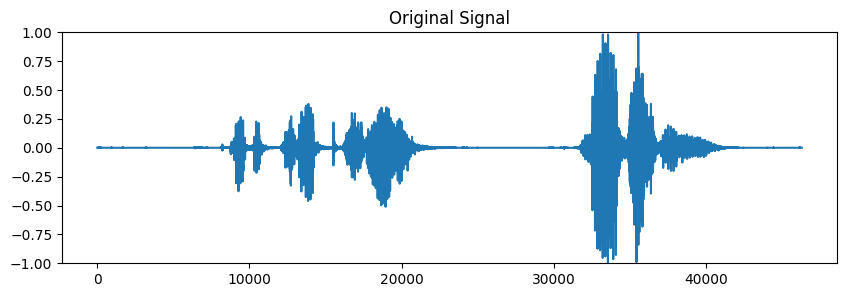

In [31]:
    # Plot original signal
plt.figure(figsize=(10, 3))
plt.plot(x)
plt.ylim(-1, 1)
plt.title("Original Signal")
plt.show()

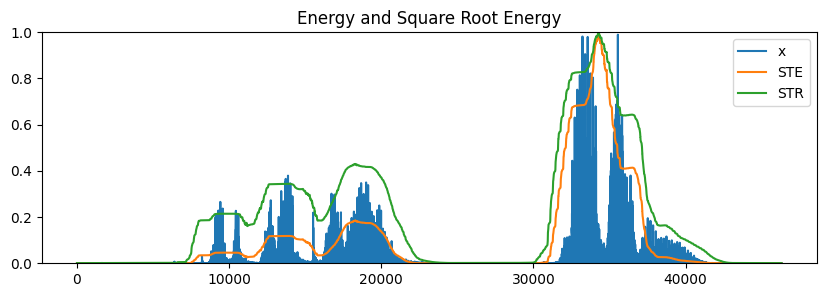

In [32]:
# Length of analysis window: 200 ms 

win = int(fs * 0.2)

# Instantaneous energy
ste = np.convolve(x ** 2, np.ones(win), 'same')
ste = ste / np.max(ste)

# Square root version
str_ = np.sqrt(ste)

# Plot energy and square root energy
plt.figure(figsize=(10, 3))
plt.plot(x)
plt.plot(ste)
plt.plot(str_)
plt.ylim(0, 1)
plt.legend(["x", "STE", "STR"])
plt.title("Energy and Square Root Energy")
plt.show()

Jak widzimy przez to żę okno zaimplementowane za pomocą splotu z wektorem samych jedynek, które działa na podstawie średniej z 200 milisekund co powoduje ze w przypadku sygnałów które mają duże amplitudy blisko siebie to średnia i średnia zpierwiastkowana ,,łapią" oba szczyty co powoduje kompletne pominięcie ,,doliny" przez średnią a nawet zwiększoną wartość w tamtym miejscu. 

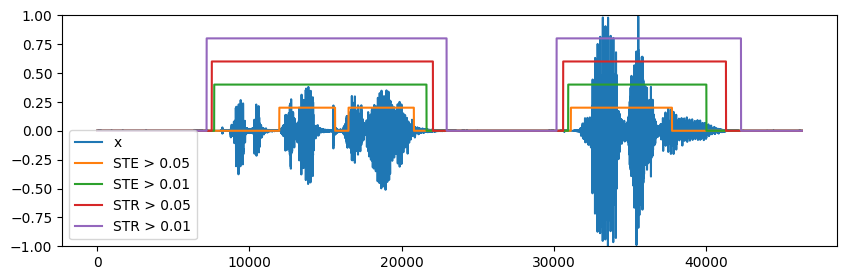

In [33]:
# second window of matlab notebook
plt.figure(figsize=(10, 3))
plt.plot(x)
plt.ylim(-1, 1)
plt.plot(0.2 * (ste > 0.05))
plt.plot(0.4 * (ste > 0.01))
plt.plot(0.6 * (str_ > 0.05))
plt.plot(0.8 * (str_ > 0.01))
plt.legend(["x", "STE > 0.05", "STE > 0.01", "STR > 0.05", "STR > 0.01"], loc="lower left")
plt.show()

Ten wykres pokazuje nam że ciężkie jest również odróznienie mowy od ciszy za pomocą stałych progów decyzyjnych ze wsględu na duży zakres dynamiczny mowy.

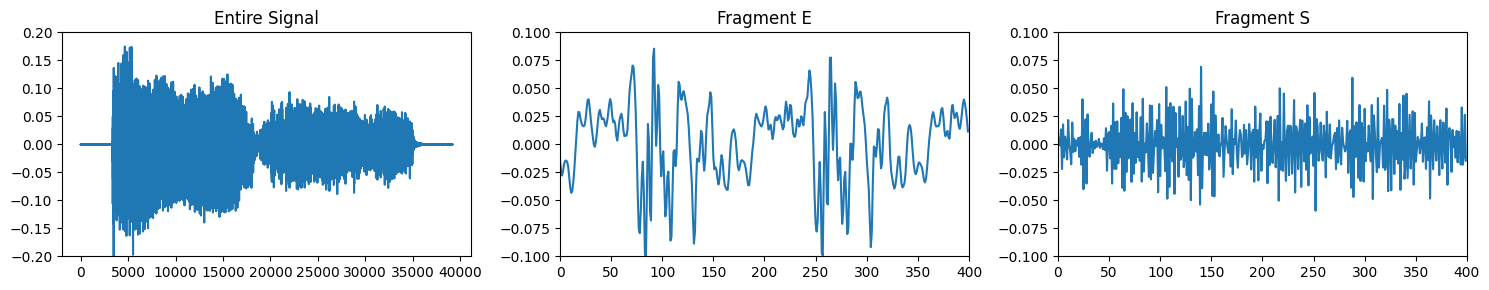

In [34]:
# third window
x, fs = librosa.load("es.wav", sr=None)

# Define window size
win = int(fs * 0.025)

# Plot the entire signal and cropped fragments
plt.figure(figsize=(15, 3))
plt.subplot(1, 3, 1)
plt.plot(x)
plt.title("Entire Signal")
plt.ylim(-0.2, 0.2)

plt.subplot(1, 3, 2)
e_crop = x[10000:10000+win]
plt.plot(e_crop)
plt.title("Fragment E")
plt.xlim(0, win)
plt.ylim(-0.1, 0.1)

plt.subplot(1, 3, 3)
s_crop = x[25000:25000+win]
plt.plot(s_crop)
plt.title("Fragment S")
plt.xlim(0, win)
plt.ylim(-0.1, 0.1)

plt.tight_layout()
plt.show()

Wykresy pokazują nam wykresy w dziedzinie czasu dla wypowiedzianych liter E oraz S. Możemy zauwarzyć zupełnie rózną charakterytykę sygnałua mianowicie, sygnał s ma dużo większą częstotliwość niż fragment ,,E".

In [35]:
def zerocrossrate(x):
    zc = np.diff(np.sign(x))
    zcr = np.sum(zc != 0) / len(x)
    return zcr

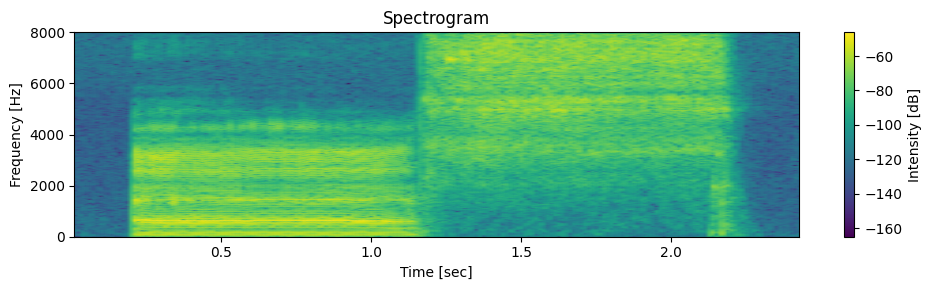

In [36]:
# Define window size
win = int(fs * 0.025)

# Create figure
plt.figure(figsize=(10, 3))
plt.subplot(1, 1, 1)

# Plot spectrogram
f, t, Sxx = spectrogram(x, fs, nperseg=win, noverlap=win//2)
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, fs/2)
plt.colorbar(label='Intensity [dB]')
plt.title('Spectrogram')

plt.tight_layout()
plt.show()

To samo możemy zaobserwować tutaj, tym razem w dziedzinie częstotliwości. E ma większość skladowych niskich natomiast s większość częstotliwośći wysokich. 

In [37]:
print(zerocrossrate(e_crop))
print(zerocrossrate(s_crop))

0.0925
0.775


Ten wynik pokazuje nam że głoski bezdzwięczne mają dużo większy współczynnik przechodzenia przez linie zero niż głoski dzwięczne. głoski dzwięczne mają bardziej silny ton podstawowy który powoduje że przechodzi on rzadziej przez zero niż przy głoskach bezdzwięcznych w których większa ilość i amplituda wyższych składowych harmonicznych powoduje częstsze przejścia przez linie zera.

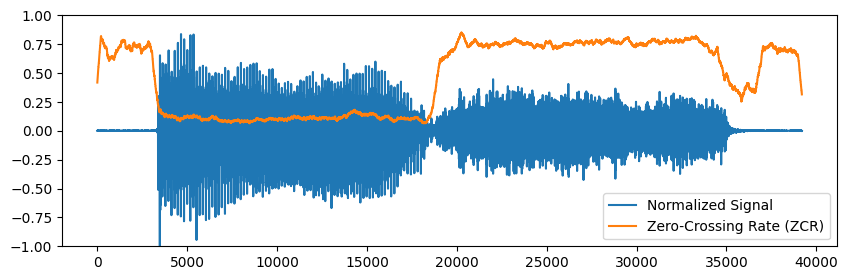

In [38]:
# Define window size
win = int(fs * 0.025)

# Create x1 and x2
x1 = x
x2 = np.concatenate(([0], x[:-1]))  # Pad x2 with 0 at the beginning

# Calculate diff
diff = np.sign(x1) != np.sign(x2)

# Calculate zero-crossing rate (zcr)
zcr = np.convolve(diff.astype(float), np.ones(win) / win, "same")

# Plot normalized signal and zcr
plt.figure(figsize=(10, 3))
plt.plot(x / np.max(np.abs(x)), label='Normalized Signal')
plt.plot(zcr, label='Zero-Crossing Rate (ZCR)')
plt.ylim(-1, 1)
plt.legend()
plt.show()

Jeszcze raz pokazanie tego samego czyli związku przejść przez linię zera z dźwięcznością bądź bezdzwięcznośćią głosek

In [39]:
from scipy.signal import find_peaks
from scipy.signal import correlate
import librosa

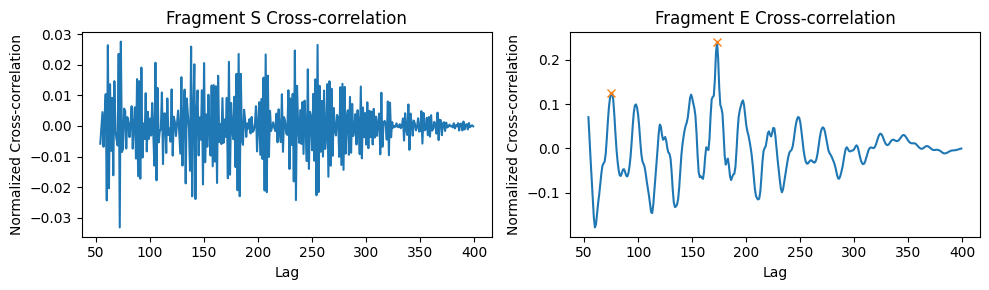

In [40]:
# Define window size
win = int(fs * 0.025)

# Define f_max and lag_min
f_max = 300
lag_min = int(fs / f_max)

# Crop fragments
e_crop = x[10000:10000+win]
s_crop = x[25000:25000+win]

# Create tiled layout
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)

# Cross-correlation and peak detection for fragment s_crop
c = correlate(s_crop, s_crop, mode='full')
lags = np.arange(-len(s_crop) + 1, len(s_crop))
c = c[lags > lag_min]
lags = lags[lags > lag_min]
peaks, _ = find_peaks(c, prominence=0.2, width=3)
plt.plot(lags, c)
plt.plot(lags[peaks], c[peaks], 'x')
plt.title('Fragment S Cross-correlation')
plt.xlabel('Lag')
plt.ylabel('Normalized Cross-correlation')

plt.subplot(1, 2, 2)

# Cross-correlation and peak detection for fragment e_crop
c = correlate(e_crop, e_crop, mode='full')
lags = np.arange(-len(e_crop) + 1, len(e_crop))
c = c[lags > lag_min]
lags = lags[lags > lag_min]
peaks, _ = find_peaks(c, prominence=0.2, width=3)
plt.plot(lags, c)
plt.plot(lags[peaks], c[peaks], 'x')
plt.title('Fragment E Cross-correlation')
plt.xlabel('Lag')
plt.ylabel('Normalized Cross-correlation')

plt.tight_layout()
plt.show()

Większa o rząd wielkości auto korelacja dzwięku "e" po 173ms pokazuje że jest to sygnał nie tak złożony i stochastyczy jak "s".

In [41]:
print(lags[peaks])

[ 75 173]


In [42]:
lags[np.argmax(c)]

173

# Pitchwin

In [43]:
def pitchwin(x, fs, win):
    pitch_contour = []

    for i in range(0, len(x), win):
        x_window = x[i:i+win]

        autocorr = np.correlate(x_window, x_window, mode='full')

        autocorr = autocorr[len(autocorr)//2:]

        autocorr /= np.max(autocorr)

        lag_min = int(fs / 300)
        lag_max = int(fs / 50)

        lag_range = np.arange(lag_min, lag_max + 1)
        max_peak_index = lag_range[np.argmax(autocorr[lag_min:lag_max + 1])]
        pitch = fs / max_peak_index

        pitch_contour.append(pitch)

    pitch_contour = np.repeat(pitch_contour, win)[:len(x)]

    return pitch_contour


(0.0, 200.0)

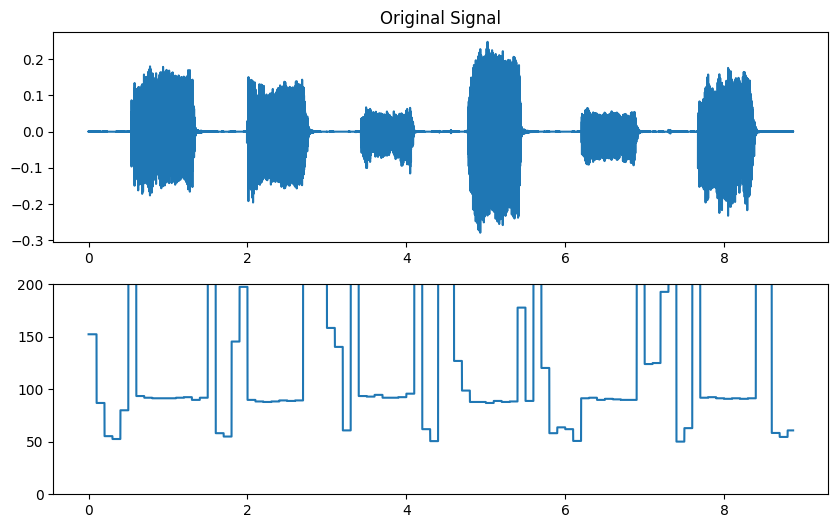

In [44]:
# Load audio
x, fs = librosa.load("aeiouy.wav", sr=None)

# Time vector
t = np.linspace(0, len(x)/fs, len(x))

# Define window size
win = int(fs * 0.1)

# Create figure
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)

# Plot original signal
plt.plot(t, x)
plt.title('Original Signal')


f0 = pitchwin(x, fs, win)
plt.subplot(2, 1, 2)

# Plot pitch contour
plt.plot(t, f0)
plt.ylim(0, 200)

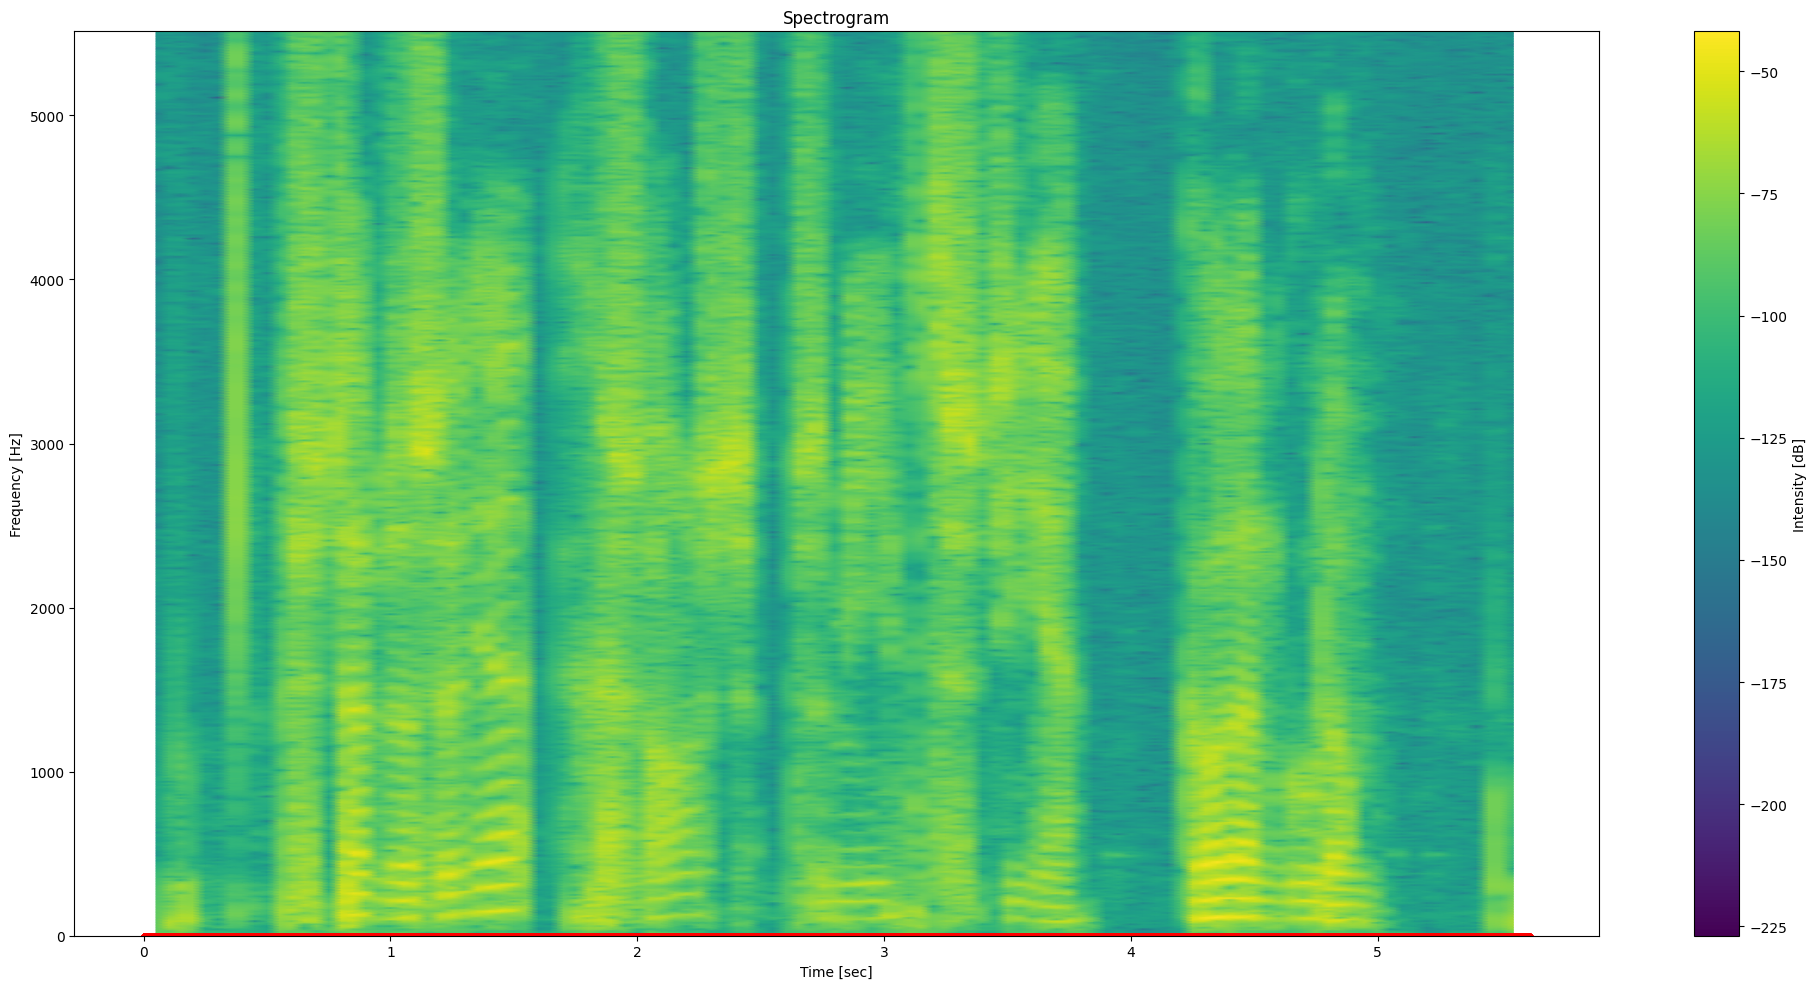

In [45]:
# Load audio
x, fs = librosa.load("golem.wav", sr=None)

# Define window size
win = int(fs * 0.1)

# Time vector
t = np.linspace(0, len(x)/fs, len(x))

f0 = pitchwin(x, fs, win)

# Create figure
plt.figure(figsize=(20, 10))

# Plot spectrogram
f, t_spec, Sxx = spectrogram(x, fs, nperseg=win, noverlap=win//2)
plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, fs/8)
plt.colorbar(label='Intensity [dB]')
plt.title('Spectrogram')

# Plot pitch contour
plt.plot(t, f0 / 1000, 'r.', linewidth=0.1)

plt.tight_layout()
plt.show()


# Zadanie

Powyżej widzimy spektrum aeiouy gdzie każda litera wygląda trochę jak ,,drabina" z różnymi szerokościami i rozłożeniem ,,szczebli". Widzimy zatem głoski dzwięczne.

In [46]:
def sliding_zcr(x, win):
    zcr = np.zeros(len(x))
    for i in range(len(x)):
        start = max(0, i - win)
        end = min(len(x), i + win)
        zc = np.diff(np.sign(x[start:end]))
        zcr[i] = np.sum(zc != 0) / (end - start)
    return zcr  


In [47]:
def label(x, fs, energy_threshold=0.1):
    # Length of analysis window: 200 ms
    win = int(fs * 0.2)

    # Instantaneous energy
    ste = np.convolve(x ** 2, np.ones(win), 'same')
    ste = ste / np.max(ste)

    # Square root version
    str_ = np.sqrt(ste)
    
    zcr = sliding_zcr(x, int(fs * 0.1))

    # Calculate labels based on energy threshold
    lbls = np.zeros_like(x)
    lbls[(ste > energy_threshold) | (str_ > energy_threshold)] = 1
    lbls[(lbls == 1) & (zcr < 0.10)] = 2

    return lbls

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

# Load audio
x, fs = librosa.load("golem.wav", sr=None)

print(fs)

# Normalize audio
x = x / np.max(np.abs(x))

lbls = label(x, fs)
print(len(x), len(lbls))

44100
247680 247680


In [49]:
f0 = pitchwin(x, fs, round(fs * 0.1))

print(f0)

[147.4916388 147.4916388 147.4916388 ... 300.        300.
 300.       ]


Dzięki temu kodowi możemy wyróznić elemęty z dużym zero crossing rate(metodą sliding_zcr() oraz połączyć oznaczanie elementów dziwięku za pomocą funkcji lable() która ocenia również czy dany element jest głosem czy nie na podstawie progu decyzyujnego mocy.

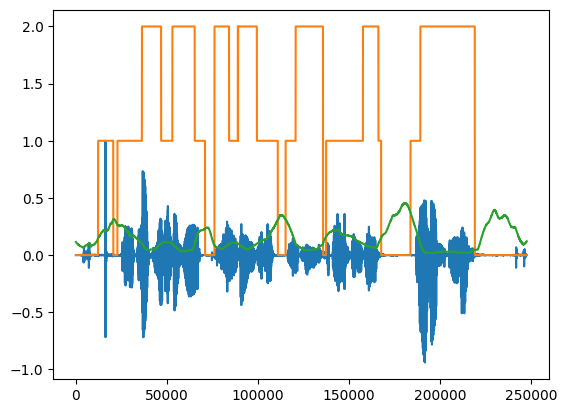

In [50]:
plt.plot(x)
plt.plot(lbls)
plt.plot(sliding_zcr(x, int(fs*0.1)))
plt.show()

Na wykresie widzimy efekty kodu gdzie nagranie zostało zcharakteryzowane za pomocą ZCR(zero crossing rate aby wykryć dzwięczność bądz niedzwięczność) oraz progu decyzyjnego na moc sygnału co pozwala nam za pomocą decyzji w formie drzewiastej rozdzielić ciszę od mowy a następnie głoski dzwięczne od bezdzwięcznych.

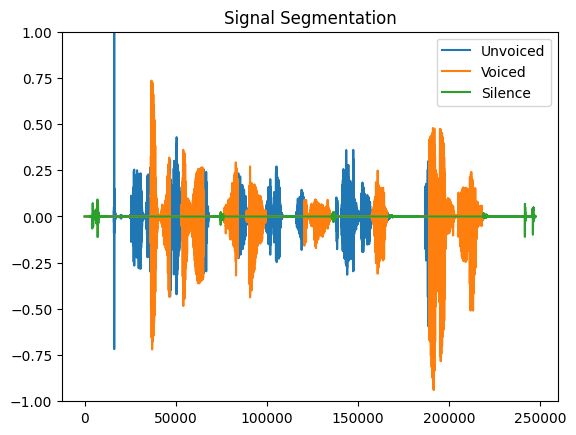

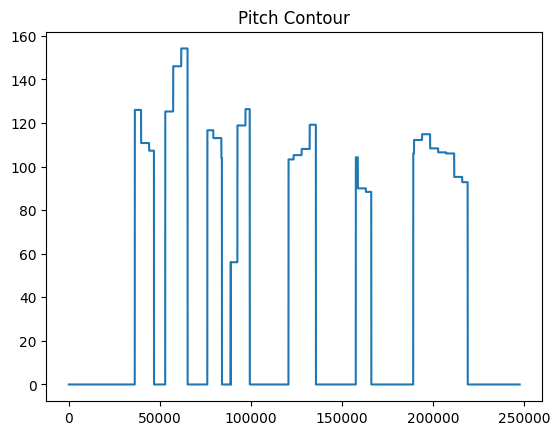

In [51]:
# Apply conditions to f0
f0[lbls != 2] = 0

# Create separate signals based on labels
silence = np.copy(x)
silence[lbls != 0] = 0

unvoiced = np.copy(x)
unvoiced[lbls != 1] = 0

voiced = np.copy(x)
voiced[lbls != 2] = 0

# Plot signals
plt.figure()
plt.title("Signal Segmentation")
plt.plot(unvoiced, label="Unvoiced")
plt.plot(voiced, label="Voiced")
plt.plot(silence, label="Silence")
plt.ylim(-1, 1)
plt.legend()
plt.show()

plt.figure()
plt.plot(f0)
plt.title("Pitch Contour")
plt.show()

Efekt końcowy z głosem w którym zaznaczone są elemęty dzwięczne i bezdzwięczne oddzielone od ciszy.